# Analyzing the LHC Output

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import cf_xarray

## Start up PBS cluster
 - may need to adjust project and/or walltime

In [44]:
# Setup your PBSCluster
from dask_jobqueue import PBSCluster
from dask.distributed import Client

project = 'P08010000' # Input your project code here

ncores=1 # The number of cores you want
nmem='2GB' # Amount of memory - can scale down as number of workers increases

cluster = PBSCluster(
    cores=ncores,
    memory=nmem,
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/$USER/dask-local', # Use your dask-local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project=project,
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up - detemine based on amount of data being read in (e.g., number of years, number of variables, history frequency)
cluster.scale(20)

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41056 instead
  f"Port {expected} is already in use.\n"


In [45]:
client

<Client: 'tcp://10.12.206.46:41442' processes=0 threads=0, memory=0 B>

## Some custom functions
TO DO: write these in a utils file and import

In [2]:
def get_files(htape,yr0=1850,yr1=2014):
    d='/glade/campaign/asp/djk2120/PPEn11/transient/hist/' # SET THIS FOR HISTORY FILE LOCATION

    #find all files
    fs   = np.array(sorted(glob.glob(d+'*'+htape+'*')))
    yrs  = np.array([int(f.split(htape)[1][1:5]) for f in fs])
    keys = np.array([f.split('.clm2')[0][-7:] for f in fs])
    #print(yrs)
    
    #bump back yr0, if needed
    uyrs=np.unique(yrs)
    #print(uyrs)
    dy=uyrs[1]-yrs[0]
    yr0=dy*int(yr0/dy)
    #print(yr0)
    
    #print(yr1)
    #find index to subset files
    ix   = (yrs>=yr0)&(yrs<=yr1)
    yrs  = yrs[ix]
    keys = keys[ix]

    #subset and reshape files
    ny=np.sum(keys=='LHC0000')
    nens = int(len(keys)/ny)
    files = fs[ix].reshape([nens,ny])

    #convert to list of lists
    files = [list(f) for f in files]
    
    return files,np.unique(keys)

In [3]:
def add_params(ds,df,keys):
    mems=df['member'].values
    ix1=0*mems==1
    for key in keys:
        ix1=(ix1)|(mems==key)

    nens=len(ds.ens)    
    ix2=0*np.arange(nens)==1
    for mem in mems:
        ix2=(ix2)|(ds.key==mem)


    params=[]    
    for p in df.keys():
        if p!='member':
            x=xr.DataArray(np.nan+np.zeros(nens),dims='ens')
            x[ix2]=df[p][ix1]
            ds[p]=x
            params.append(p)
    ds['params']=xr.DataArray(params,dims='param')

In [4]:
def get_ds(dvs,htape,yr0=1850,yr1=2014,dropdef=False):
    
    def preprocess(ds):
        return ds[dvs]
    
    #print(yr1)
    #read in the data
    files,keys = get_files(htape,yr0,yr1)
    #print(files)
    if dropdef:
        files = files[1:]
        keys  = keys[1:]
    
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                       parallel=True,preprocess=preprocess)
    
    #fix the time dimension, if needed
    yr0_full=str(ds['time.year'].values[0])
    if (htape=='h0')|(htape=='h1'):
        ds['time']=xr.cftime_range(yr0_full,periods=len(ds.time),freq='MS',calendar='noleap')
    
    #add some param info, etc.
    df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt') # SET THIS FOR PARAMETER KEY LOCATION
    ds['key']=xr.DataArray(keys,dims=['ens'])
    add_params(ds,df,keys)
    
    #add landarea info
    la_file = '/glade/work/djk2120/CLM5PPE/pyth/sparsegrid_landarea.nc' # SET THIS FOR LANDAREA FILE LOCATION
    la = xr.open_dataset(la_file).landarea  #km2
    ds['la'] = la
    
    #add some extra variables, e.g. lat/lon
    tmp = xr.open_dataset(files[0][0])
    for v in tmp.data_vars:
        if 'time' not in tmp[v].dims:
            ds[v]=tmp[v]  
    
    #select time indices according to specified years
    ds_mod = ds.sel(time=slice(str(yr0),str(yr1)))
    
    #return ds
    return ds_mod

In [5]:
def gmean(da,la,cf=1):
    #global mean
    xg=cf/la.sum()*(la*da).sum(dim='gridcell').compute()
    return xg

In [6]:
whit = xr.open_dataset('./whit/whitkey.nc')
def bmean(da,la):
    g=whit.biome
    xb=1/la.groupby(g).sum()*(la*da).groupby(g).sum(dim='gridcell').compute()
    xb['biome_name']=xr.DataArray(whit.biome_name.values,dims='biome')
    return xb

In [7]:
def amean(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa

In [8]:
def get_map(da):
    '''
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...
    '''
    
    #ACCESS the sparsegrid info
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #DIAGNOSE the shape of the output map
    newshape = []
    coords=[]
    #  grab any dimensions that arent "gridcell" from da
    for coord,nx in zip(da.coords,da.shape):
        if nx!=400:
            newshape.append(nx)
            coords.append((coord,da[coord].values))
    #  grab lat/lon from sg
    for coord in ['lat','lon']:
        nx = len(sg[coord])
        newshape.append(nx)
        coords.append((coord,sg[coord].values))

    #INSTANTIATE the outgoing array
    array = np.zeros(newshape)+np.nan
    nd    = len(array.shape)
    
    #FILL the array - MAY NEED TO SET FILE LOCATION
    ds = xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/transient/hist/PPEn11_transient_LHC0000.clm2.h0.2005-02-01-00000.nc')
    for i in range(400):
        lat=ds.grid1d_lat[i]
        lon=ds.grid1d_lon[i]
        cc = sg.rcent.sel(lat=lat,lon=lon,method='nearest')
        ix = sg.cclass==cc
        
        
        if nd==2:
            array[ix]=da.isel(gridcell=i)
        else:
            nx = ix.sum().values
            array[:,ix]=np.tile(da.isel(gridcell=i).values[:,np.newaxis],[1,nx])
    
     
    #OUTPUT as DataArray
    da_map = xr.DataArray(data=array,name=da.name,coords=coords)
    da_map.attrs=da.attrs

    return da_map

## Load the ensemble

In [105]:
%%time

# Set data variables of interest
#dvs = ['GPP'] # starting with GPP only
#dvs = ['TLAI','GPP','SOILWATER_10CM','EFLX_LH_TOT','QHR'] # five relevant vars
#dvs = ['FSDS', 'RAIN', 'SNOW', 'TBOT', 'QBOT', 'WIND'] # forcing variables
#dvs = ['NBP'] # for cumulative land carbon sink plots
dvs = ['NEE','NPP'] # carbon cycle variables
#dvs = ['TLAI'] # checking LAI metrics

# Set history tape (output frequency)
htape='h0'

# Set years (optional, will default to 1850-2014)
#yr0=2005
#yr1=2014

#ds = get_ds(dvs,htape,yr0,yr1)
ds = get_ds(dvs,htape)

CPU times: user 4min 27s, sys: 5.27 s, total: 4min 33s
Wall time: 10min 29s


In [106]:
ds

<xarray.Dataset>
Dimensions:              (ens: 501, time: 1980, gridcell: 400, param: 32, lon: 144, lat: 96, landunit: 1267, column: 2974, pft: 8574)
Coordinates:
  * time                 (time) object 1850-01-01 00:00:00 ... 2014-12-01 00:...
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Dimensions without coordinates: ens, gridcell, param, landunit, column, pft
Data variables: (12/79)
    NEE                  (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
    NPP                  (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
    key                  (ens) <U7 'LHC0000' 'LHC0001' ... 'LHC0499' 'LHC0500'
    FUN_fracfixers       (ens) float64 nan 0.7783 0.3193 ... 0.186 0.2621 0.4221
    KCN                  (ens) float64 nan 0.358 0.5488 ... 0.9964 0.9123 0.8392
    a_fix                (ens) float64 nan 0.255 0.6302 ... 0.4222 0.5339 0.1443
    ...                   ...
    pfts1d_wtlunit       (pft) float64 ...
    pfts1d_wtcol         (pft) float64 ...
    pfts1d_itype_veg     (pft) float64 ...
    pfts1d_itype_col     (pft) float64 ...
    pfts1d_itype_lunit   (pft) float64 ...
    pfts1d_active        (pft) float64 ...
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 09/28/22 14:19:35
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0000.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [14]:
# get parameter names
ds.params

<xarray.DataArray 'params' (param: 32)>
array(['FUN_fracfixers', 'KCN', 'a_fix', 'crit_dayl', 'd_max', 'fff',
       'froot_leaf', 'fstor2tran', 'grperc', 'jmaxb0', 'jmaxb1', 'kcha',
       'kmax', 'krmax', 'leaf_long', 'leafcn', 'lmr_intercept_atkin',
       'lmrha', 'lmrhd', 'medlynintercept', 'medlynslope', 'nstem',
       'psi50', 'q10_mr', 'slatop', 'soilpsi_off', 'stem_leaf',
       'sucsat_sf', 'theta_cj', 'tpu25ratio', 'tpuse_sf', 'wc2wjb0'],
      dtype='<U19')
Dimensions without coordinates: param

In [107]:
# check data variables
dvs

['NEE', 'NPP']

In [15]:
# indexing by parameter name
#ds.medlynslope

In [16]:
# get ensemble member names
#ds.key

In [18]:
# indexing by ensemble member
#ds.medlynslope[ds.key=='LHC0001']

### Check forcing data
Previous issue with QBOT in 2014 GSWP3 data

CPU times: user 47.9 s, sys: 1.3 s, total: 49.2 s
Wall time: 1min 38s


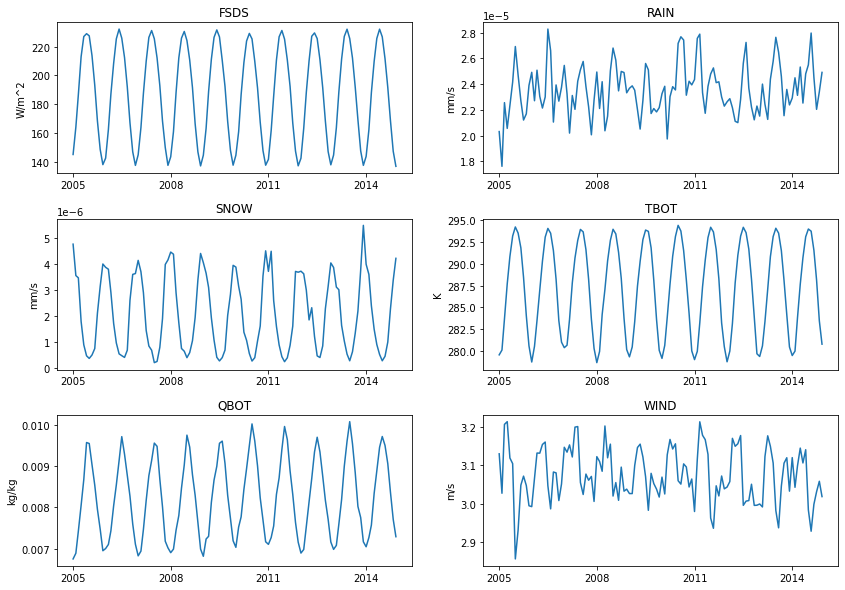

In [17]:
%%time
# check forcing data for any inconsistences around 2014
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,10))
ax = axs.ravel()
for i,var in enumerate(dvs):
    var_GM = gmean(ds[var],ds.la)
    var_GM.sel(ens=0).plot(ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel(ds[var].units)
    ax[i].set_title(var)
    
plt.subplots_adjust(wspace=0.2, hspace=0.3)
#plt.savefig('../figs/lhc/forcing_default.png', bbox_inches='tight')

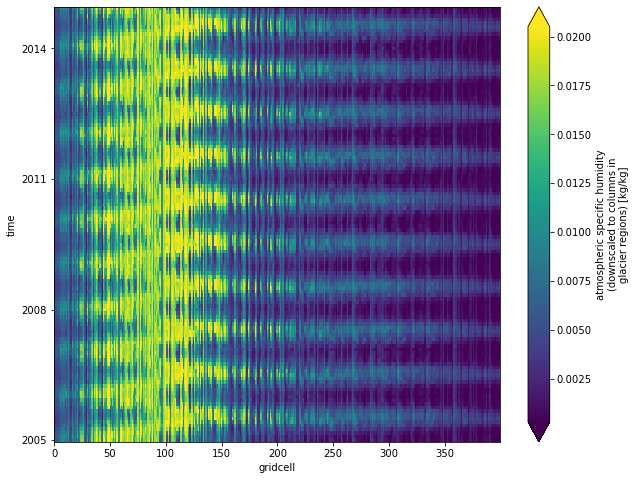

In [18]:
ds['QBOT'].sel(ens=0).plot(robust=True, figsize=(10,8))
#plt.savefig('../figs/lhc/QBOT_default.png', bbox_inches='tight')

In [19]:
# find the index of the min QBOT value (constant across gridcells)
#ds['QBOT'].sel(ens=0).idxmin(dim='time').values # actual time value
ds['QBOT'].sel(ens=0).argmin(dim='time').values # time index

array([ 89,   5,  89,   5,  93,  30,  17,  80,  17,  17,  30,  43,  69,
        43, 105,  67,  30,  44, 117,  31,  90,  54,  31,   7, 103,  30,
         6,  43,  57,  43,  54, 105,  30,  30,  30,  31,  30,   7,  68,
       103,  92,   7,  29,   6, 103,  19,  30,  30,   7, 116,  44,   7,
       115,  53,   7,   6,  77,  30,  31,  32,  32,   7,   7,  41,  30,
        30,   8,   7,  30,  19,   8, 119, 103,  92,  20,  56,  32,  92,
        32,  94,  91,  41,  42,   7, 109,   7,  42,  62,  56,  84,  73,
        35,  62,  93,  72,   0,  85,  84,   0,  66,  37,   0,  84,  37,
        37, 108,  12,  49, 109,  36,  24,  37,  74,   0,  37,  36,  17,
        36, 108, 108,   1,  74,  74,   0,  26,  74,  37,  13, 110,  25,
        37,  25,  37,  37,  71,  74,  37, 101,  26, 110,  26,  72,  37,
        74,  51,  26, 110,  85,  71,  37,  72,  85, 111, 110,  12,  37,
        62,  63,  52,  75,  51,   3,  71,  15,  98,  71,  15,  51,  72,
        71,  71,  85,  52,  60,  72,   0,  36, 109,  24,  60,  7

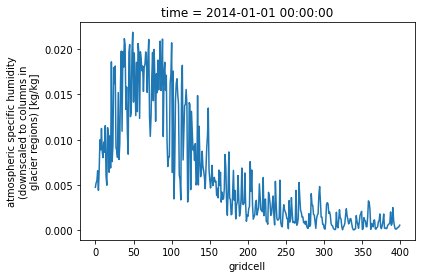

In [20]:
ds['QBOT'].isel(ens=0, time=108).plot()

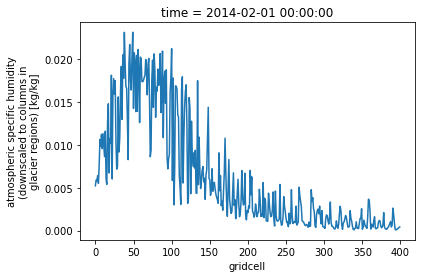

In [21]:
ds['QBOT'].isel(ens=0, time=109).plot()

In [22]:
# use get_map function to map sparse to global grid
QBOT_def_map = get_map(ds['QBOT'].isel(ens=0, time=108))

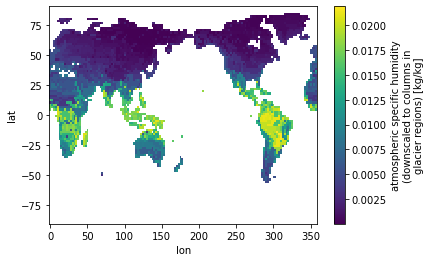

In [23]:
QBOT_def_map.plot()

### Compute and plot global mean GPP for the default params

CPU times: user 9.44 s, sys: 248 ms, total: 9.69 s
Wall time: 21.6 s


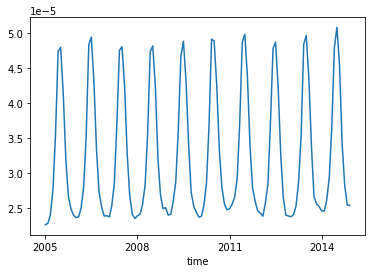

In [29]:
%%time
GPP_GM = gmean(ds['GPP'],ds.la)
GPP_GM.sel(ens=0).plot();

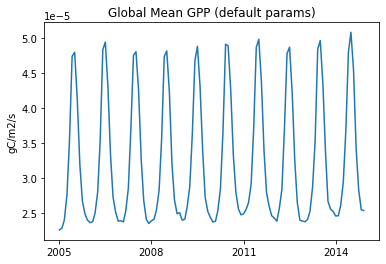

In [30]:
# another way to select the ensemble member
GPP_GM[ds.key=='LHC0000'].plot()
plt.xlabel('')
plt.ylabel('gC/m2/s')
plt.title('Global Mean GPP (default params)');
#plt.savefig('../figs/lhc/GPP_GM_default.png', bbox_inches='tight')
#plt.savefig('../figs/lhc/GPP_GM_default_2005-2013.png', bbox_inches='tight')

In [31]:
# st dev across ensemble members
GPP_GM_spread = GPP_GM.std(dim='ens')

#### plot with st dev spread 

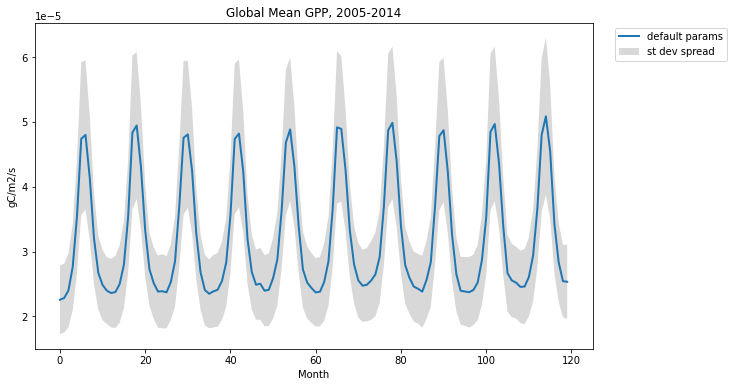

In [85]:
# can't quite get time axis to work here with fill_between
nyrs = 1+(yr1-yr0)
# create monthly time indices
tx = np.linspace(0,nyrs*12-1,nyrs*12)
plt.figure(figsize=(10,6))
plt.plot(tx, GPP_GM.sel(ens=0), linewidth=2, label='default params')
plt.fill_between(tx, GPP_GM.sel(ens=0)-GPP_GM_spread, GPP_GM.sel(ens=0)+GPP_GM_spread, alpha=0.3, facecolor='grey', label='st dev spread')
#plt.xticks(np.arange(12)+1, ['J','F','M','A','M','J','J','A','S','O','N','D'])
plt.xlabel('Month')
#plt.ylim([0,5])
plt.ylabel('gC/m2/s')
plt.legend(bbox_to_anchor=[1.25, 1])
plt.title('Global Mean GPP, '+str(yr0)+'-'+str(yr1));
#plt.savefig('../figs/lhc/GPP_GM_spread_stdev_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

In [34]:
# min/max across ensemble members
GPP_GM_min = GPP_GM.min(dim='ens')
GPP_GM_max = GPP_GM.max(dim='ens')

#### plot with min/max spread

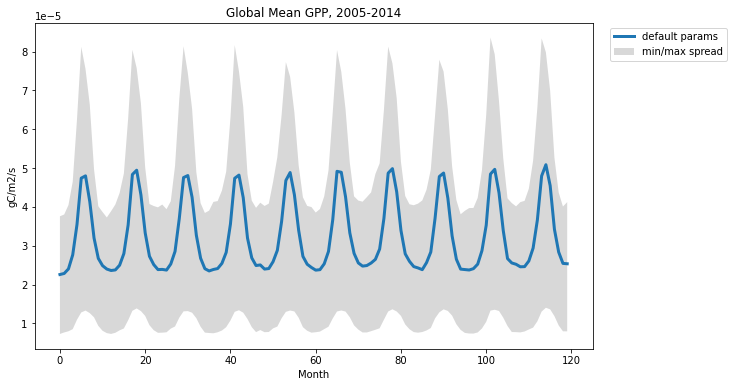

In [86]:
plt.figure(figsize=(10,6))
plt.plot(tx, GPP_GM.sel(ens=0), linewidth=3, label='default params')
plt.fill_between(tx, GPP_GM_min, GPP_GM_max, alpha=0.3, facecolor='grey', label='min/max spread')
plt.xlabel('Month')
plt.ylabel('gC/m2/s')
plt.legend(bbox_to_anchor=[1.25, 1])
plt.title('Global Mean GPP, '+str(yr0)+'-'+str(yr1));
#plt.savefig('../figs/lhc/GPP_GM_spread_minmax_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

#### plot all the ensemble members

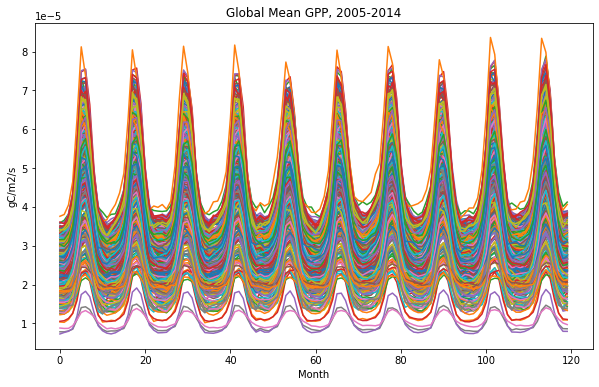

In [88]:
plt.figure(figsize=(10,6))
plt.plot(tx, GPP_GM.transpose());
plt.xlabel('Month')
plt.ylabel('gC/m2/s')
plt.title('Global Mean GPP, '+str(yr0)+'-'+str(yr1));
#plt.savefig('../figs/lhc/GPP_GM_allens_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

### Compute and plot global mean QHR

CPU times: user 6.01 s, sys: 177 ms, total: 6.19 s
Wall time: 11.3 s


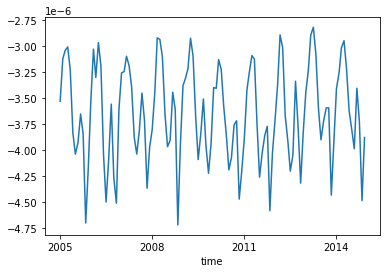

In [14]:
%%time
QHR_GM = gmean(ds['QHR'],ds.la)
QHR_GM.sel(ens=0).plot();

In [15]:
# min/max across ensemble members
QHR_GM_min = QHR_GM.min(dim='ens')
QHR_GM_max = QHR_GM.max(dim='ens')

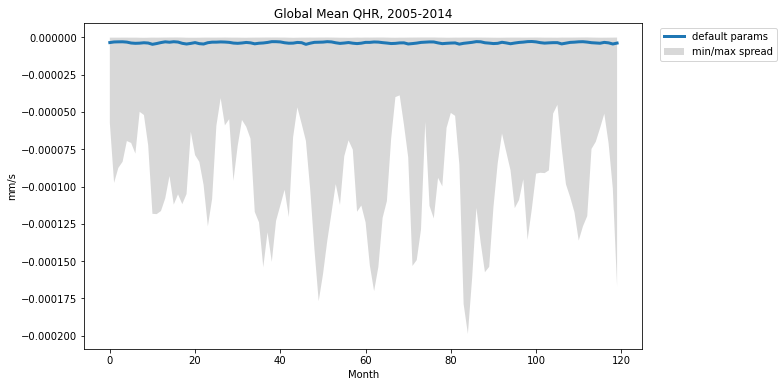

In [20]:
plt.figure(figsize=(10,6))
nyrs = 1+(yr1-yr0)
tx = np.linspace(0,nyrs*12-1,nyrs*12)
plt.plot(tx, QHR_GM.sel(ens=0), linewidth=3, label='default params')
plt.fill_between(tx, QHR_GM_min, QHR_GM_max, alpha=0.3, facecolor='grey', label='min/max spread')
plt.xlabel('Month')
plt.ylabel(ds['QHR'].units)
plt.legend(bbox_to_anchor=[1.25, 1])
plt.title('Global Mean QHR, '+str(yr0)+'-'+str(yr1));
#plt.savefig('../figs/lhc/QHR_GM_spread_minmax_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

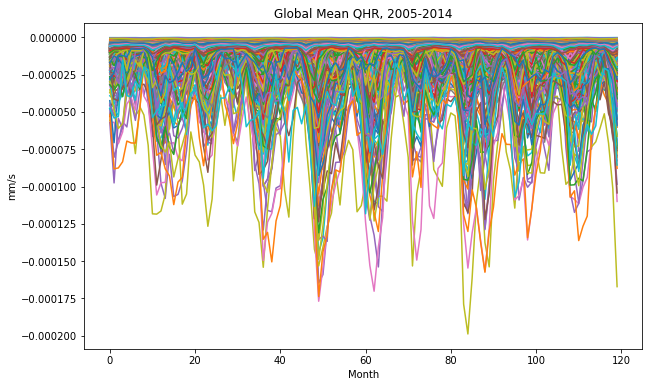

In [21]:
plt.figure(figsize=(10,6))
plt.plot(tx, QHR_GM.transpose());
plt.xlabel('Month')
plt.ylabel(ds['QHR'].units)
plt.title('Global Mean QHR, '+str(yr0)+'-'+str(yr1));

### Compute global mean TLAI and compare to metrics notebook
For debugging amean discrepancies (resolved)

In [62]:
# metrics notebook
def amean_metrics(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa

In [63]:
len(np.unique(ds['TLAI']['time.year']))

10

In [64]:
days_pm=[31,28,31,30,31,30,31,31,30,31,30,31]
xr.DataArray(np.tile(days_pm,10),dims='time')

<xarray.DataArray (time: 120)>
array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31])
Dimensions without coordinates: time

In [65]:
ds['TLAI']

<xarray.DataArray 'TLAI' (ens: 501, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(501, 120, 400), dtype=float32, chunksize=(1, 60, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

In [66]:
ds['TLAI']['time.daysinmonth']

<xarray.DataArray 'daysinmonth' (time: 120)>
array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31])
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00

In [67]:
xr.DataArray(np.tile(days_pm,10),dims='time') - ds['TLAI']['time.daysinmonth']

<xarray.DataArray (time: 120)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00

In [52]:
# how is the time being read in?
f='/glade/campaign/asp/djk2120/PPEn11/transient/hist/PPEn11_transient_LHC0492.clm2.h0.2005-02-01-00000.nc'
test_nc = xr.open_dataset(f)
test_nc['TLAI']

<xarray.DataArray 'TLAI' (time: 60, gridcell: 400)>
array([[4.107085, 3.425231, 7.522046, ..., 0.      , 0.      , 0.      ],
       [4.133079, 3.440408, 7.539663, ..., 0.      , 0.      , 0.      ],
       [2.661544, 2.523761, 5.723192, ..., 0.      , 0.      , 0.      ],
       ...,
       [4.31914 , 3.528582, 7.526682, ..., 0.      , 0.      , 0.      ],
       [4.298252, 3.514139, 7.506546, ..., 0.      , 0.      , 0.      ],
       [4.294174, 3.510112, 7.502349, ..., 0.      , 0.      , 0.      ]],
      dtype=float32)
Coordinates:
  * time     (time) object 2005-02-01 00:00:00 ... 2010-01-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

In [58]:
test_nc['time'] = xr.cftime_range('2005',periods=len(test_nc.time),freq='MS',calendar='noleap')
test_nc['TLAI']

<xarray.DataArray 'TLAI' (time: 60, gridcell: 400)>
array([[4.107085, 3.425231, 7.522046, ..., 0.      , 0.      , 0.      ],
       [4.133079, 3.440408, 7.539663, ..., 0.      , 0.      , 0.      ],
       [2.661544, 2.523761, 5.723192, ..., 0.      , 0.      , 0.      ],
       ...,
       [4.31914 , 3.528582, 7.526682, ..., 0.      , 0.      , 0.      ],
       [4.298252, 3.514139, 7.506546, ..., 0.      , 0.      , 0.      ],
       [4.294174, 3.510112, 7.502349, ..., 0.      , 0.      , 0.      ]],
      dtype=float32)
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2009-12-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

In [68]:
ds_means = [amean(gmean(ds[x], ds.la)) for x in dvs]

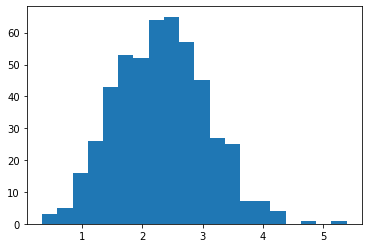

In [69]:
plt.hist(ds_means[0], bins=20);

In [70]:
#metrics notebook
ds_means_metrics=[gmean(amean_metrics(ds[x]).mean(dim='year'),ds.la) for x in dvs]

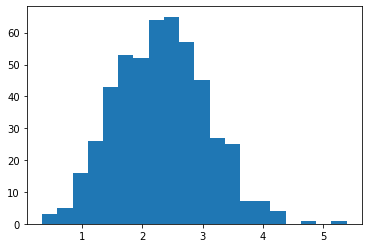

In [71]:
plt.hist(ds_means_metrics[0], bins=20);

In [75]:
# diff is now negligible!
ds_means_diff = ds_means[0] - ds_means_metrics[0]
ds_means_diff

<xarray.DataArray (ens: 501)>
array([-4.44089210e-16, -4.44089210e-16, -4.44089210e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.44089210e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.22044605e-16, -2.22044605e-16, -4.44089210e-16,
       -4.44089210e-16,  0.00000000e+00, -2.22044605e-16, -4.44089210e-16,
        4.44089210e-16,  0.00000000e+00,  0.00000000e+00, -2.22044605e-16,
       -4.44089210e-16, -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
       -4.44089210e-16,  0.00000000e+00,  0.00000000e+00, -1.11022302e-16,
       -2.22044605e-16,  2.22044605e-16,  0.00000000e+00,  0.00000000e+00,
        4.44089210e-16,  0.00000000e+00, -8.88178420e-16, -4.44089210e-16,
       -4.44089210e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.22044605e-16, -4.44089210e-16,  0.00000000e+00,  0.00000000e+00,
       -4.44089210e-16,  4.44089210e-16,  0.00000000e+00,  0.00000000e+00,
       -4.44089210e-16, -2.22044605e-16, -4.44089210e-16,  0.00000000e+00,
       -2.22044605e-16,  4.44089210e-16, -8.88178420e-16,  0.00000000e+00,
        0.00000000e+00, -4.44089210e-16,  0.00000000e+00,  0.00000000e+00,
       -4.44089210e-16, -4.44089210e-16, -2.22044605e-16,  0.00000000e+00,
       -4.44089210e-16, -2.22044605e-16, -2.22044605e-16,  0.00000000e+00,
        0.00000000e+00, -4.44089210e-16,  0.00000000e+00, -4.44089210e-16,
       -4.44089210e-16, -2.22044605e-16,  4.44089210e-16, -8.88178420e-16,
...
       -4.44089210e-16,  0.00000000e+00,  0.00000000e+00, -4.44089210e-16,
       -4.44089210e-16, -8.88178420e-16, -4.44089210e-16,  0.00000000e+00,
       -4.44089210e-16, -4.44089210e-16, -2.22044605e-16, -4.44089210e-16,
        0.00000000e+00,  0.00000000e+00, -2.22044605e-16, -8.88178420e-16,
       -4.44089210e-16,  0.00000000e+00, -4.44089210e-16,  0.00000000e+00,
        0.00000000e+00,  4.44089210e-16, -2.22044605e-16, -4.44089210e-16,
       -1.33226763e-15,  0.00000000e+00,  0.00000000e+00, -8.88178420e-16,
       -4.44089210e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.44089210e-16,  0.00000000e+00,  4.44089210e-16,
       -4.44089210e-16,  0.00000000e+00, -8.88178420e-16, -2.22044605e-16,
       -2.22044605e-16,  0.00000000e+00, -4.44089210e-16, -6.66133815e-16,
       -4.44089210e-16, -4.44089210e-16,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -8.88178420e-16,  0.00000000e+00, -4.44089210e-16,
        4.44089210e-16,  0.00000000e+00, -4.44089210e-16, -4.44089210e-16,
        4.44089210e-16,  0.00000000e+00, -4.44089210e-16, -4.44089210e-16,
       -4.44089210e-16, -4.44089210e-16, -2.22044605e-16, -2.22044605e-16,
       -4.44089210e-16, -8.88178420e-16, -8.88178420e-16,  0.00000000e+00,
       -4.44089210e-16,  0.00000000e+00,  0.00000000e+00, -4.44089210e-16,
       -2.22044605e-16, -2.22044605e-16,  2.22044605e-16, -2.22044605e-16,
        0.00000000e+00])
Dimensions without coordinates: ens

## Compute global means

In [48]:
%%time
ds_gmeans = [gmean(ds[x], ds.la) for x in dvs]

CPU times: user 31.4 s, sys: 1.17 s, total: 32.6 s
Wall time: 49.9 s


In [49]:
# st dev across ensemble members
ds_gmeans_spread = [x.std(dim='ens') for x in ds_gmeans]

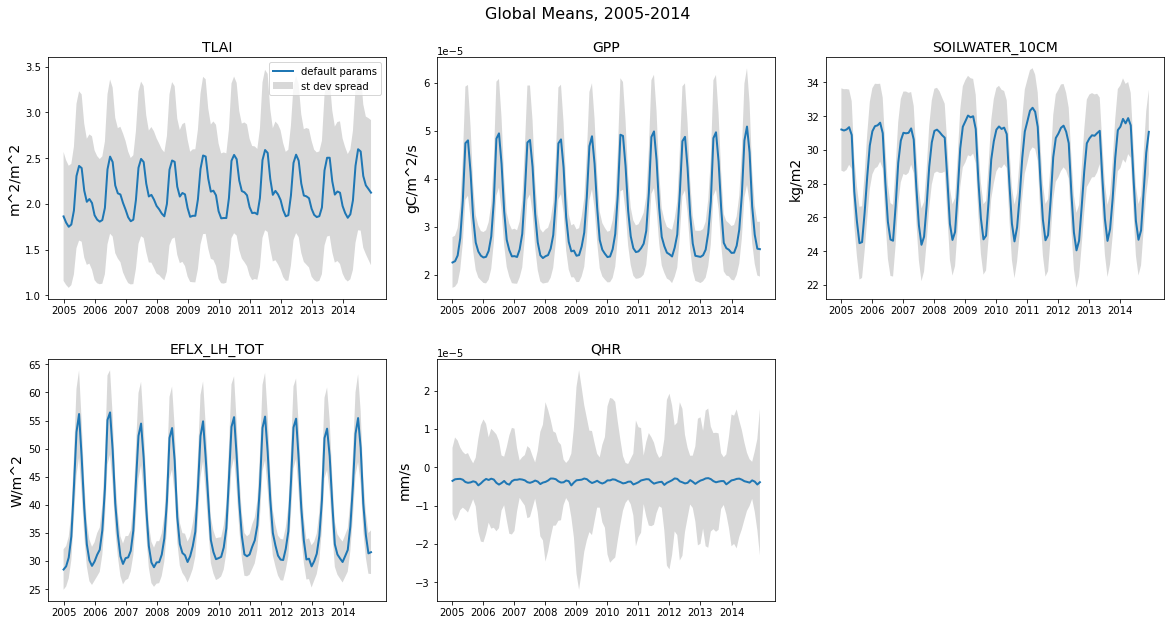

In [55]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
ax = axs.ravel()
fig.delaxes(ax[5]) # remove unecessary panel

# create monthly time indices
nyrs = 1+(yr1-yr0)
tx = np.linspace(0,nyrs*12-1,nyrs*12)
    
for i,var in enumerate(dvs):    
    ax[i].plot(tx, ds_gmeans[i].sel(ens=0), linewidth=2, label='default params')
    ax[i].fill_between(tx, ds_gmeans[i].sel(ens=0)-ds_gmeans_spread[i], ds_gmeans[i].sel(ens=0)+ds_gmeans_spread[i], alpha=0.3, facecolor='grey', label='st dev spread')
    ax[i].set_xticks(np.arange(nyrs)*12, np.arange(yr0,yr1+1))
    ax[i].set_ylabel(ds[var].units, fontsize=14)
    if i==0:
        ax[i].legend()
    ax[i].set_title(var, fontsize=14)

fig.suptitle('Global Means, '+str(yr0)+'-'+str(yr1), fontsize=16, y=0.95)
plt.subplots_adjust(wspace=0.15, hspace=0.25)
#plt.savefig('../figs/lhc/fivevars_GM_spread_stdev_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

In [56]:
# min/max across ensemble members
ds_gmeans_min = [x.min(dim='ens') for x in ds_gmeans]
ds_gmeans_max = [x.max(dim='ens') for x in ds_gmeans]

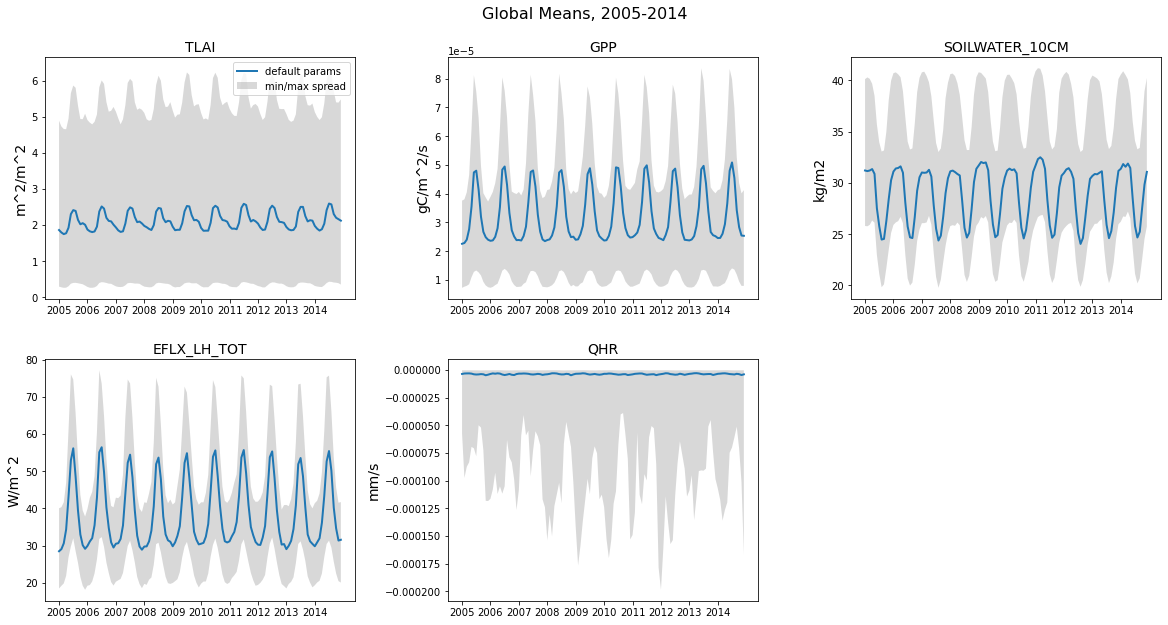

In [60]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
ax = axs.ravel()
fig.delaxes(ax[5]) # remove unecessary panel

# create monthly time indices
nyrs = 1+(yr1-yr0)
tx = np.linspace(0,nyrs*12-1,nyrs*12)
    
for i,var in enumerate(dvs):    
    ax[i].plot(tx, ds_gmeans[i].sel(ens=0), linewidth=2, label='default params')
    ax[i].fill_between(tx, ds_gmeans_min[i], ds_gmeans_max[i], alpha=0.3, facecolor='grey', label='min/max spread')
    # display lines instead of fill between - noting that the min/max values may not be from the same ensemble member across time
    # though judging from the individual ensemble member timeseries the min/max values likely are from the same ensemble member for some variables
    #ax[i].plot(tx, ds_gmeans[i].sel(ens=0), linewidth=3, color='k', label='default params')
    #ax[i].plot(tx, ds_gmeans_min[i], 'b', label='min values')
    #ax[i].plot(tx, ds_gmeans_max[i], 'r', label='max values')
    ax[i].set_xticks(np.arange(nyrs)*12, np.arange(yr0,yr1+1))
    ax[i].set_ylabel(ds[var].units, fontsize=14)
    if i==0:
        ax[i].legend()
    ax[i].set_title(var, fontsize=14)
    
fig.suptitle('Global Means, '+str(yr0)+'-'+str(yr1), fontsize=16, y=0.95)
plt.subplots_adjust(wspace=0.3, hspace=0.25)
#plt.savefig('../figs/lhc/fivevars_GM_spread_minmax_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

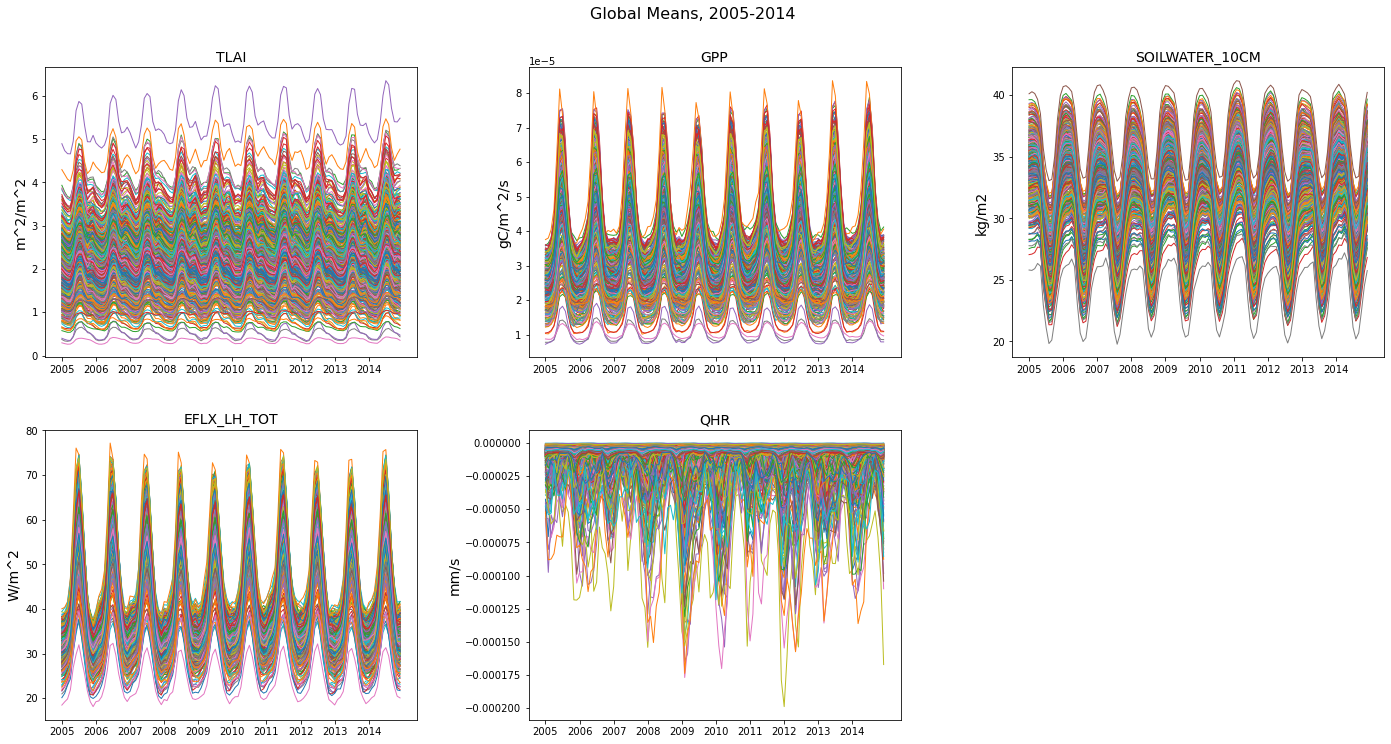

In [63]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24,12))
ax = axs.ravel()
fig.delaxes(ax[5]) # remove unecessary panel

# create monthly time indices
nyrs = 1+(yr1-yr0)
x = np.linspace(0,nyrs*12-1,nyrs*12)
    
for i,var in enumerate(dvs):    
    ax[i].plot(x, ds_gmeans[i].transpose(), linewidth=1)
    ax[i].set_xticks(np.arange(nyrs)*12, np.arange(yr0,yr1+1))
    ax[i].set_ylabel(ds[var].units, fontsize=14)
    ax[i].set_title(var, fontsize=14)

fig.suptitle('Global Means, '+str(yr0)+'-'+str(yr1), fontsize=16, y=0.95)
plt.subplots_adjust(wspace=0.3, hspace=0.25)
#plt.savefig('../figs/lhc/fivevars_GM_allens_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

### Compute annual mean global mean GPP

In [37]:
%%time
GPP_GM_AM = amean(GPP_GM)

CPU times: user 5.81 ms, sys: 0 ns, total: 5.81 ms
Wall time: 112 ms


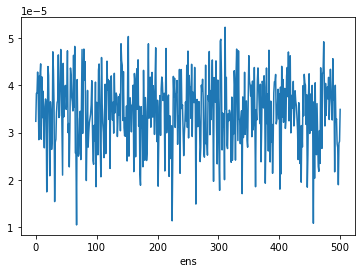

In [38]:
GPP_GM_AM.plot();

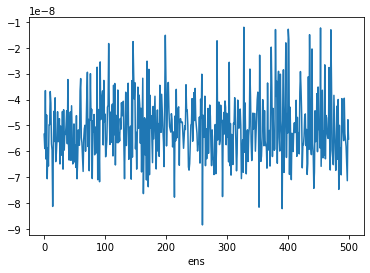

In [52]:
# alternate computation of amean taking a straight average over monthly time indices - not exactly the same due to variations in month length
GPP_GM_AM_compare = GPP_GM.mean(dim='time')
(GPP_GM_AM_compare - GPP_GM_AM).plot();

In [45]:
%%time
# compute avg 2005-2014 GPP
v = 'GPP'
y = amean(gmean(ds[v],ds.la))

CPU times: user 5.95 s, sys: 276 ms, total: 6.23 s
Wall time: 10.3 s


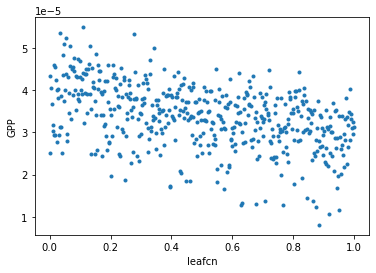

In [55]:
#avg 2005-2014 GPP vs. leafcn
p = 'leafcn'
x = ds[p]

plt.plot(x,y,'.')
plt.xlabel(p)
plt.ylabel(v);

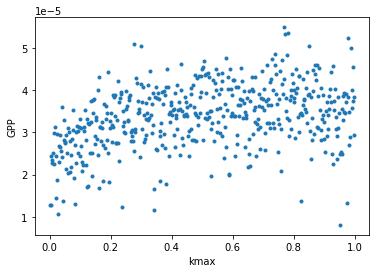

In [56]:
#avg 2005-2014 GPP vs. kmax
p = 'kmax'
x = ds[p]

plt.plot(x,y,'.')
plt.xlabel(p)
plt.ylabel(v);

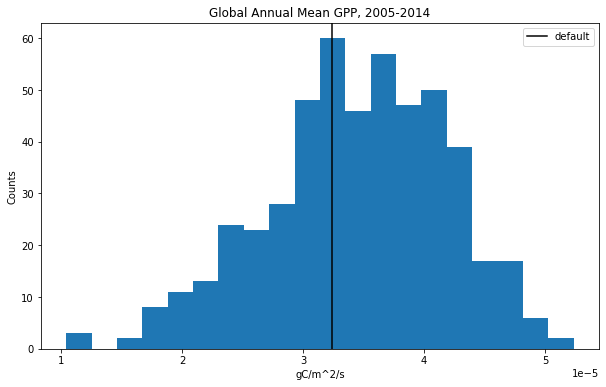

In [81]:
plt.figure(figsize=(10,6))
plt.hist(GPP_GM_AM, bins=20)
plt.axvline(GPP_GM_AM[0], color='k', label='default')
plt.xlabel('gC/m^2/s')
plt.ylabel('Counts')
plt.legend()
plt.title('Global Annual Mean GPP, '+str(yr0)+'-'+str(yr1));
#plt.savefig('../figs/lhc/GPP_GM_AM_withdefault_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

In [41]:
y = GPP_GM_AM
v = 'GPP'
y2 = y*10**6/12 # convert GPP gC/m^2/s to umol/m^2/s

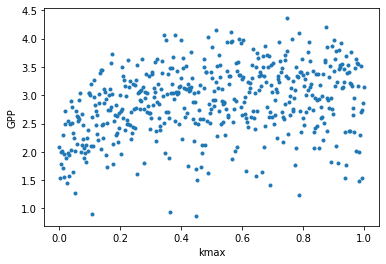

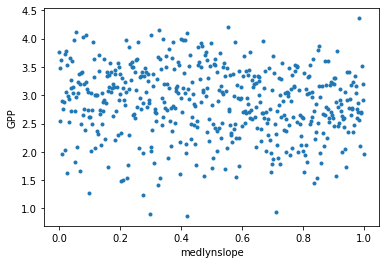

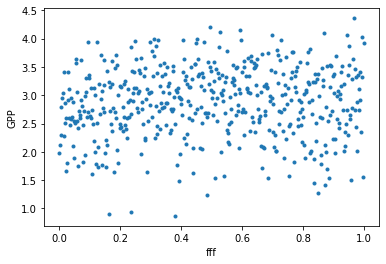

In [89]:
# plot some familiar params
params = ['kmax', 'medlynslope', 'fff']
for p in params:
    px = ds[p]
    plt.figure()
    plt.plot(px, y2, '.')
    plt.xlabel(p)
    plt.ylabel(v);

### Compute annual mean global mean QHR

In [22]:
%%time
QHR_GM_AM = amean(QHR_GM)

CPU times: user 4.49 ms, sys: 0 ns, total: 4.49 ms
Wall time: 34.7 ms


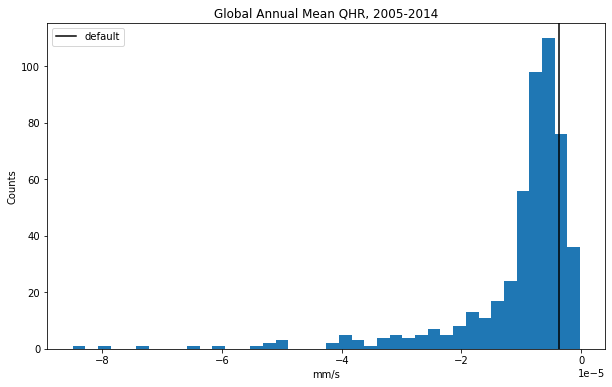

In [25]:
plt.figure(figsize=(10,6))
plt.hist(QHR_GM_AM, bins=40)
plt.axvline(QHR_GM_AM[0], color='k', label='default')
plt.xlabel(ds['QHR'].units)
plt.ylabel('Counts')
plt.legend()
plt.title('Global Annual Mean QHR, '+str(yr0)+'-'+str(yr1));
#plt.savefig('../figs/lhc/QHR_GM_AM_withdefault_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

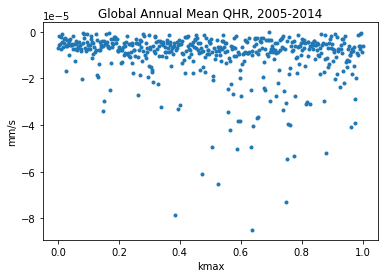

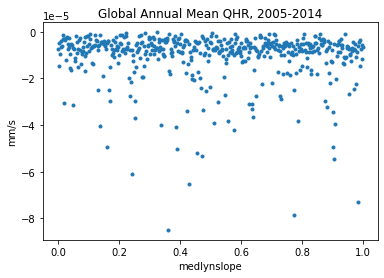

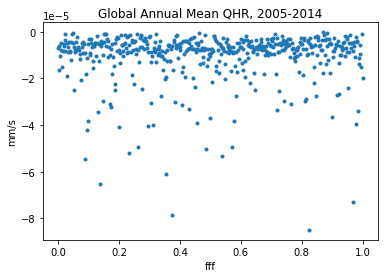

In [28]:
# plot some familiar params
params = ['kmax', 'medlynslope', 'fff']
for p in params:
    px = ds[p]
    plt.figure()
    plt.plot(px, QHR_GM_AM, '.')
    plt.xlabel(p)
    plt.ylabel(ds['QHR'].units)
    plt.title('Global Annual Mean QHR, '+str(yr0)+'-'+str(yr1));

## Compute global, annual means

In [76]:
%%time
ds_means = [amean(ds_gmeans[i]).mean(dim='year') for i,x in enumerate(dvs)]

CPU times: user 37.1 ms, sys: 15 µs, total: 37.1 ms
Wall time: 39.1 ms


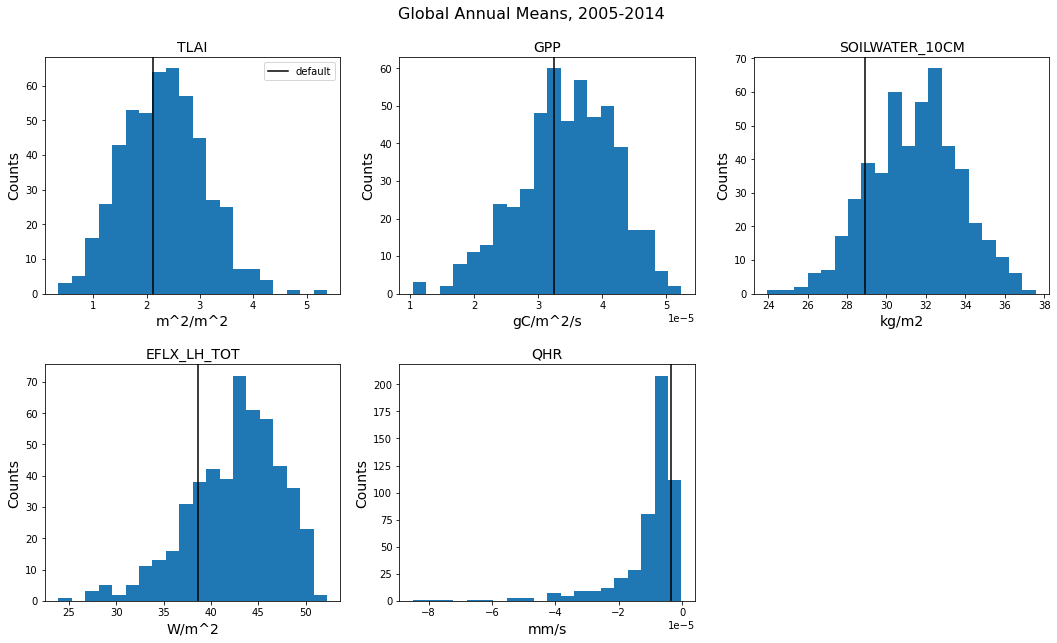

In [82]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
ax = axs.ravel()
fig.delaxes(ax[5])

for i,var in enumerate(dvs):
    ax[i].hist(ds_means[i], bins=20)
    ax[i].axvline(ds_means[i][0], color='k', label='default')
    ax[i].set_xlabel(ds[var].units, fontsize=14)
    ax[i].set_ylabel('Counts', fontsize=14)
    if i==0:
        ax[i].legend()
    ax[i].set_title(var, fontsize=14)

fig.suptitle('Global Annual Means, '+str(yr0)+'-'+str(yr1), fontsize=16, y=0.95)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
#plt.savefig('../figs/lhc/fivevars_GM_AM_withdefault_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

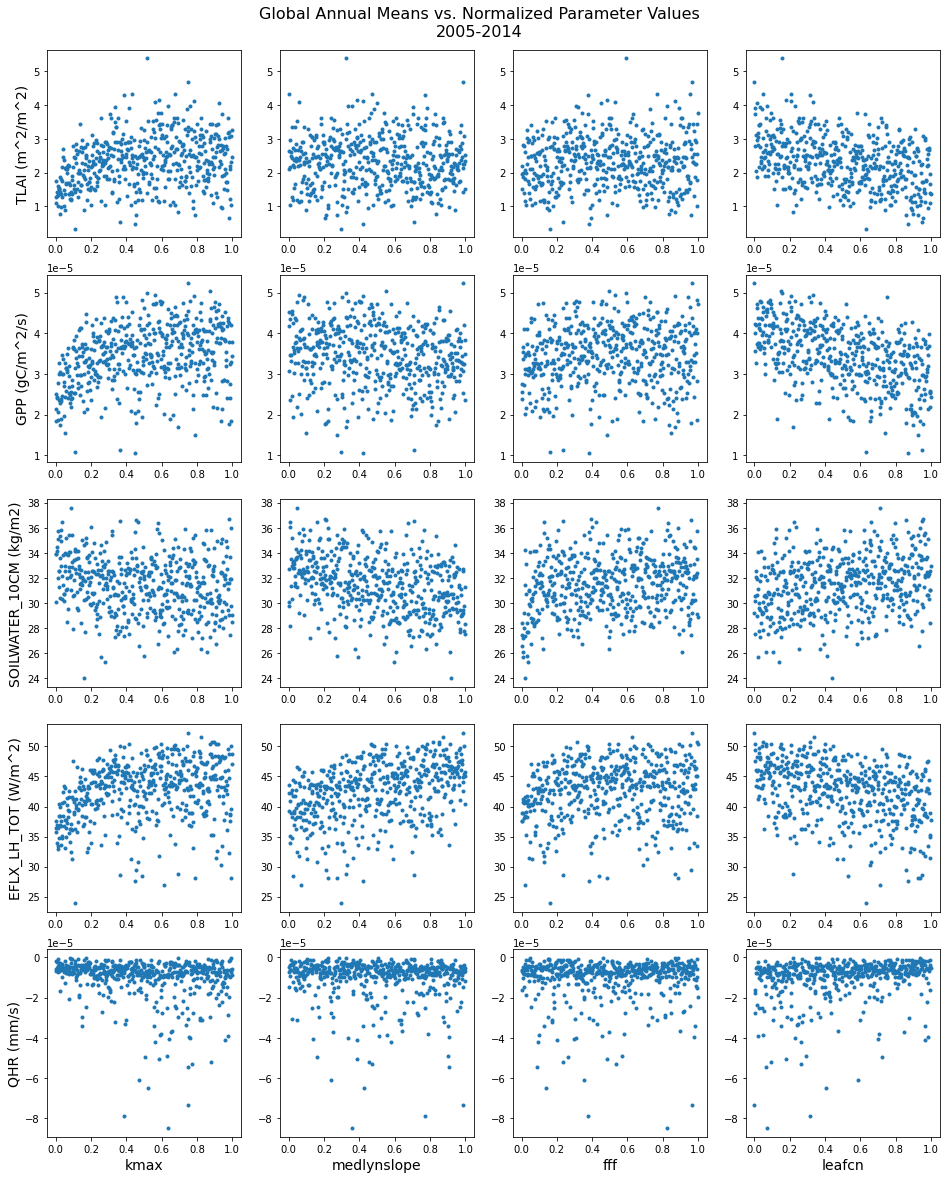

In [88]:
# plot some familiar params
params = ['kmax', 'medlynslope', 'fff', 'leafcn']
nparam = len(params)

nvars = len(dvs)

fig, axs = plt.subplots(nrows=nvars, ncols=nparam, figsize=(16,20))

for i,var in enumerate(dvs):
    for j,p in enumerate(params):
        px = ds[p]
        axs[i,j].plot(px, ds_means[i], '.')
        if i==4:
            axs[i,j].set_xlabel(p, fontsize=14)
        if j==0:
            axs[i,j].set_ylabel(var+' ('+ds[var].units+')', fontsize=14);

fig.suptitle('Global Annual Means vs. Normalized Parameter Values\n'+str(yr0)+'-'+str(yr1), fontsize=16, y=0.91)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig('../figs/lhc/fivevars_fourparams_GM_AM_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

### Compute annual mean maps

In [89]:
ds_ameans = [amean(ds[x]) for x in dvs]

In [90]:
ds_ameans_min = [x.min(dim='ens') for x in ds_ameans]
ds_ameans_max = [x.max(dim='ens') for x in ds_ameans]

In [104]:
# proving that the ensemble members for the mins are not consistent across gridcells
ds_ameans[0].argmin(dim='ens')

<xarray.DataArray (gridcell: 400)>
array([179, 179, 456, 179, 456, 179, 456, 456, 456, 456, 456, 456, 456,
       456, 370, 179, 456, 112, 224, 370,  67, 456, 192, 370, 263, 456,
       323, 389, 112,  98, 456,  18, 456, 456, 456, 370, 122, 456, 224,
       224, 172, 102, 172, 456,  44, 361, 389,  99,  44, 224, 361, 224,
       361, 220,  99, 389, 263, 361, 349, 361, 361, 224, 224, 263, 224,
       224,  44, 224, 361, 224,  44, 263, 224, 237, 263, 224,   0, 456,
       263,  65, 389, 436, 224, 456, 224, 456, 224, 224, 456, 370, 224,
       224, 224, 456,  31,  65, 172, 112, 224,  44,  44, 361, 224,  65,
       370,   0, 224, 224, 224, 224, 361, 361, 289, 339, 361, 361, 321,
       224, 361, 224, 224, 107, 321, 224, 224, 172, 224, 361,  22,  44,
       201,  44, 172,  44, 361,   1,  31, 224, 224,  44, 224, 224,   0,
         1, 361, 224, 456, 201, 224, 224,  18, 172, 446, 456, 456, 456,
         5, 224, 112, 201, 224, 292, 224, 302, 201, 201, 201, 201, 201,
       224, 224, 201, 263, 456, 456, 456, 201,  18, 310, 310, 224, 224,
       403, 224, 179, 201, 224, 456, 263, 292, 112, 456, 456,  18, 263,
       224, 456,  67,  18, 456, 456, 456, 201, 456, 179, 456, 219, 112,
       456, 403, 219, 263, 403, 403, 456, 456, 456, 112, 456, 456, 456,
       403, 403, 192, 370, 456, 456, 403, 179,  74, 403, 403, 403, 403,
       339, 112, 179, 403, 403, 403, 403, 403, 192, 403, 403, 456, 456,
       403, 403, 403, 192, 370, 456, 456, 456, 456, 456, 403, 403, 456,
       456, 403, 456, 179, 456, 456, 403, 225, 403, 403, 403, 403, 403,
       403, 403, 403, 403, 456, 456, 456, 456, 456, 456, 456, 179, 403,
       403, 403, 456, 456, 179,  23, 403, 225, 403, 179, 456, 403, 456,
       456, 456, 456,   5, 403,  67, 179, 456,   0, 456, 456, 465, 403,
       456, 456, 456,  67, 179, 403,   5,   2, 225, 456, 456, 403,  67,
        18,  23,   5, 436,  23, 403,  67,   1,   5, 456, 403,  23,  23,
        23,  67,  67,  23,  18,  67,  23,   5,   9, 403,   0, 403,  23,
        23,   2,  23, 403,   5,   0,   0, 179, 179,   0,  18,   0,   5,
         0,   0,  18,   5,   5,   5,   5,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  13, 345,   0,   0,
         5, 370,   0,   0,   0,   0,   0,   0,   0,   0])
Dimensions without coordinates: gridcell

In [93]:
# use get_map function to map sparse to global grid
ds_ameans_min_map = [get_map(ds_ameans_min[i]) for i,x in enumerate(ds_ameans_min)]
ds_ameans_max_map = [get_map(ds_ameans_max[i]) for i,x in enumerate(ds_ameans_max)]
ds_ameans_def_map = [get_map(ds_ameans[i][0]) for i,x in enumerate(ds_ameans)]

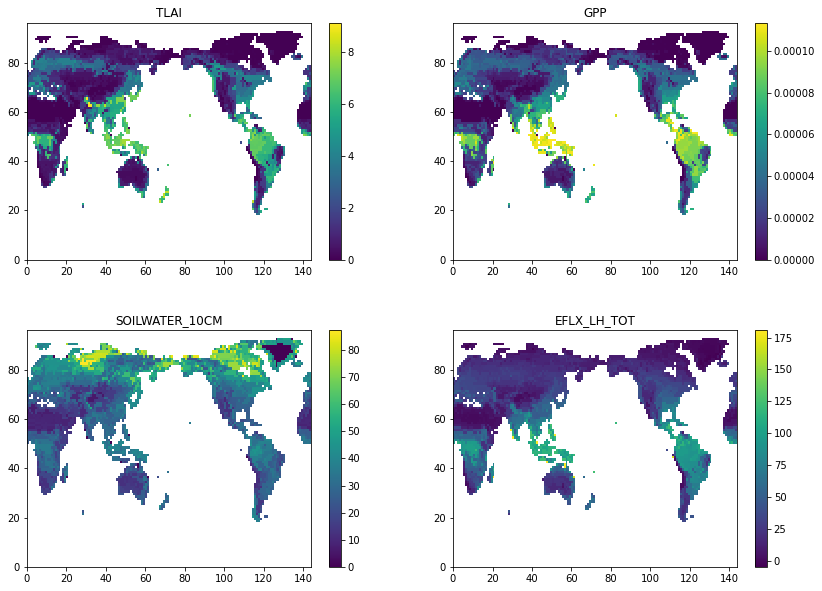

In [94]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
ax = axs.ravel()
for i,var in enumerate(dvs):
    pc = ax[i].pcolormesh(ds_ameans_def_map[i])
    ax[i].set_title(var)
    fig.colorbar(pc, ax=ax[i])
    
plt.subplots_adjust(wspace=0.2, hspace=0.3)

In [45]:
# GPP only
GPP_ameans = amean(ds['GPP'])

In [47]:
# note the way this is done it is not necessarily taking values from the same ensemble member for each gridcell, just whatever is max/min across the ensemble
GPP_ameans_min = GPP_ameans.min(dim='ens')
GPP_ameans_max = GPP_ameans.max(dim='ens')

In [49]:
GPP_ameans_def_map = get_map(GPP_ameans[0])
GPP_ameans_min_map = get_map(GPP_ameans_min)
GPP_ameans_max_map = get_map(GPP_ameans_max)

In [58]:
print(GPP_ameans_def_map.max().values)
print(GPP_ameans_max_map.max().values)

0.00011324896739296653
0.00017895063697535876


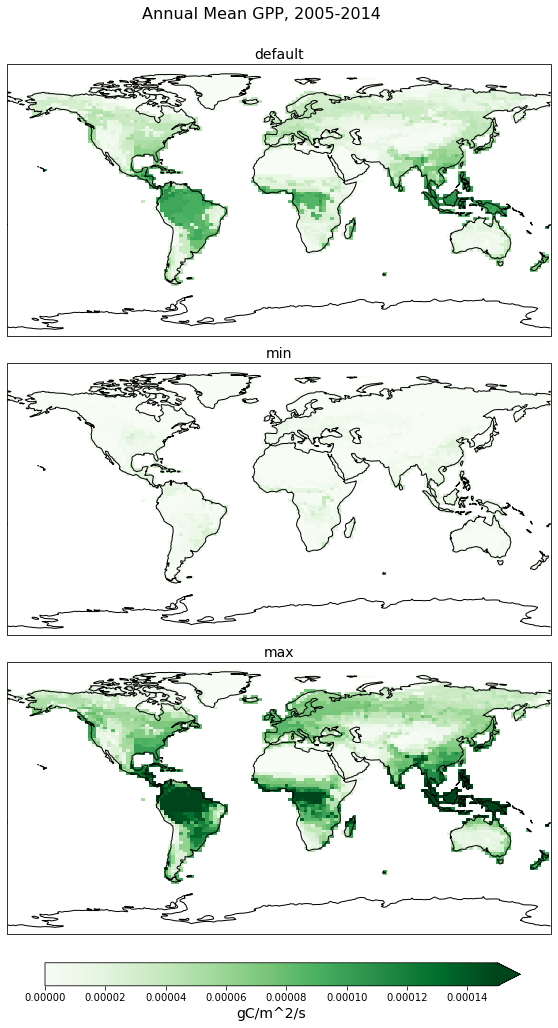

In [92]:
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20,16), subplot_kw={'projection': ccrs.PlateCarree()})
ax = axs.ravel()

vmin=0
vmax=15*10**-5

cmap = plt.cm.get_cmap('Greens')

# default
field, lon = add_cyclic_point(GPP_ameans_def_map, coord=GPP_ameans_def_map.lon)
lat = GPP_ameans_def_map.lat
pc = ax[0].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axs[0].coastlines()
ax[0].set_title('default', fontsize=14)

# min
field, lon = add_cyclic_point(GPP_ameans_min_map, coord=GPP_ameans_min_map.lon)
lat = GPP_ameans_min_map.lat
pc = ax[1].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axs[1].coastlines()
ax[1].set_title('min', fontsize=14)

# max
field, lon = add_cyclic_point(GPP_ameans_max_map, coord=GPP_ameans_max_map.lon)
lat = GPP_ameans_max_map.lat
pc = ax[2].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
axs[2].coastlines()
ax[2].set_title('max', fontsize=14)

# axes: [left, bottom, width, height]
cb_ax = fig.add_axes([0.35, 0.08, 0.33, 0.02])
# it's ok to reference the final pc plot here because they are all scaled the same with vmin/vmax
cbar = plt.colorbar(pc, cax=cb_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel(ds['GPP'].units, fontsize=14)

# for some reason this code no longer works - package versions? Doesn't like the normalize?
#norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal', extend='max')
    
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.suptitle('Annual Mean '+dvs[0]+', '+str(yr0)+'-'+str(yr1), y=0.93, fontsize=16);
#plt.savefig('../figs/lhc/GPP_AM_minmax_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

### Compute climatological seasonal cycle

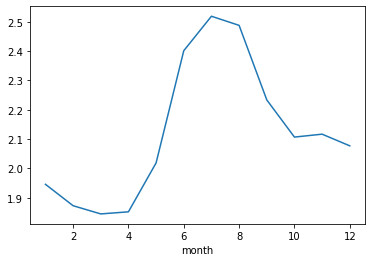

In [89]:
ds_gmeans[0].groupby('time.month').mean(dim='time').isel(ens=0).plot()

In [90]:
%%time
ds_gm_mclimo = [ds_gmeans[i].groupby('time.month').mean(dim='time') for i,x in enumerate(ds_gmeans)]

CPU times: user 26.3 ms, sys: 0 ns, total: 26.3 ms
Wall time: 26.3 ms


In [91]:
# min/max across ensemble members
ds_gm_mclimo_min = [x.min(dim='ens') for x in ds_gm_mclimo]
ds_gm_mclimo_max = [x.max(dim='ens') for x in ds_gm_mclimo]

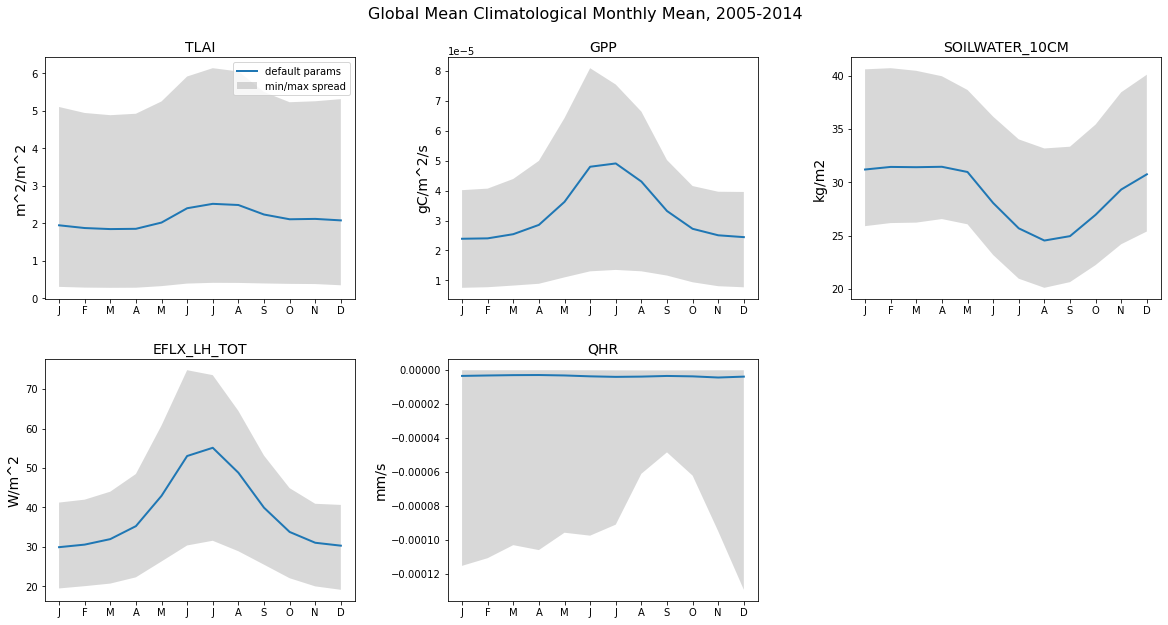

In [94]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
ax = axs.ravel()
fig.delaxes(ax[5])

# create monthly time indices
tm = np.linspace(1,12,12)
mons = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
for i,var in enumerate(dvs):    
    ax[i].plot(tm, ds_gm_mclimo[i].sel(ens=0), linewidth=2, label='default params')
    #ax[i].plot(tm, ds_gm_mclimo[i].transpose()) # all the ensemble members
    ax[i].fill_between(tm, ds_gm_mclimo_min[i], ds_gm_mclimo_max[i], alpha=0.3, facecolor='grey', label='min/max spread')
    ax[i].set_xticks(tm, mons)
    ax[i].set_ylabel(ds[var].units, fontsize=14)
    if i==0:
        ax[i].legend()
    ax[i].set_title(var, fontsize=14)

fig.suptitle('Global Mean Climatological Monthly Mean, '+str(yr0)+'-'+str(yr1), fontsize=16, y=0.95)
plt.subplots_adjust(wspace=0.3, hspace=0.25)
#plt.savefig('../figs/lhc/fivevars_GM_MC_spread_minmax_'+str(yr0)+'-'+str(yr1)+'.png', bbox_inches='tight')

### Compute cumulative NBP

In [11]:
def calc_cumulative_timeseries(da):
    '''
    Cumulative Timeseries of Net Biome Production (NBP)
    
    Parameters
    ----------
    da : xarray.DataArray
        Global sum of NBP data, units 'Pg C y^-1'
    
    Returns
    -------
    cda : xarray.DataArray
        Cumulative timeseries of NBP data, units 'Pg C'
    '''
    cda = da.cumsum(dim='time')
    cda.attrs['units'] = 'Pg C'
    return cda

In [14]:
ds['NBP']

<xarray.DataArray 'NBP' (ens: 501, time: 1980, gridcell: 400)>
dask.array<concatenate, shape=(501, 1980, 400), dtype=float32, chunksize=(1, 60, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Attributes:
    long_name:     net biome production, includes fire, landuse, harvest and ...
    units:         gC/m^2/s
    cell_methods:  time: mean

In [15]:
ds.NBP.units

'gC/m^2/s'

In [16]:
# note la units are km^2
ds.la

<xarray.DataArray 'la' (gridcell: 400)>
array([ 43876.945312,  74021.492188,  18694.408203, ...,  96467.828125,
       101825.101562,  42073.671875])
Dimensions without coordinates: gridcell
Attributes:
    long_name:  total area of represented gridcells
    units:      km2

In [17]:
cf  = 1e-15*365*24*60*60*1e6*ds.la.sum() # conversion factor for gC/m^2/s to PgC/yr

In [ ]:
# Question: what does it mean to sum over only 400 gridcells? Would it be less than a fully resolved globally gridded sum?
# Answer: no, because sparse grid is meant to represent surrounding gridcells. The landarea vector is accounting for all of the gridcells that a given sparsegrid cell is meant to represent.

In [18]:
%%time
# multiplying by cf (with land area) turns into a global sum
nbp_gm = cf*gmean(ds['NBP'],ds.la)

CPU times: user 2min 29s, sys: 2.73 s, total: 2min 31s
Wall time: 2min 43s


In [19]:
nbp_gm

<xarray.DataArray (ens: 501, time: 1980)>
array([[ -2.34929196,  -1.03410223,  -0.96948324, ..., -11.41224174,
        -10.25269781,  -6.55507597],
       [ -6.06095924,  -5.65566814,  -4.48109455, ..., -14.03205545,
        -14.36161151, -10.43655177],
       [ -3.96090221,  -2.52441813,  -2.65064144, ..., -11.92618123,
        -13.56890635,  -9.63159068],
       ...,
       [ -3.06333037,  -2.52800581,  -1.76847494, ...,  -9.02584446,
         -6.46198424,  -4.57033172],
       [ -1.55071676,  -0.33176715,  -0.39397112, ..., -10.58907563,
         -7.09781847,  -4.66155674],
       [ -3.44429417,  -2.09034548,  -1.19150309, ...,  -9.9672039 ,
        -10.59203605,  -6.58971481]])
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens

In [9]:
# Alternatively, read in previously processed data
nbp_gm = xr.open_dataarray('./processed_data/nbp_globalsum_1850-2014.nc')
nbp_gm

<xarray.DataArray (ens: 501, time: 1980)>
[991980 values with dtype=float64]
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2014-12-01 00:00:00
  * ens      (ens) object 'LHC0000' 'LHC0001' 'LHC0002' ... 'LHC0499' 'LHC0500'
Attributes:
    units:    PgC/yr

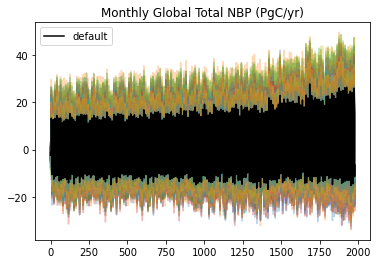

In [10]:
plt.plot(nbp_gm.transpose(),alpha=0.3);
plt.plot(nbp_gm[0], color='k', zorder=2, label='default')
plt.legend(loc=2)
plt.title('Monthly Global Total NBP (PgC/yr)');

In [12]:
# calculate the cumulative NBP on monthly values
nbp_gm_cumulative = calc_cumulative_timeseries(nbp_gm)/12 # divide by 12 months/yr to get PgC
nbp_gm_cumulative

<xarray.DataArray (ens: 501, time: 1980)>
array([[ -0.19577433,  -0.28194952,  -0.36273979, ...,  -8.7151587 ,
         -9.56955018, -10.11580651],
       [ -0.50507994,  -0.97638561,  -1.34981016, ..., -25.34200102,
        -26.53880198, -27.40851463],
       [ -0.33007518,  -0.54044336,  -0.76133015, ..., -76.86564181,
        -77.996384  , -78.79901656],
       ...,
       [ -0.25527753,  -0.46594468,  -0.61331759, ...,  -0.75456955,
         -1.29306824,  -1.67392921],
       [ -0.1292264 ,  -0.15687366,  -0.18970459, ..., -69.2084261 ,
        -69.79991098, -70.18837404],
       [ -0.28702451,  -0.46121997,  -0.5605119 , ..., -22.19425059,
        -23.07692026, -23.62606316]])
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2014-12-01 00:00:00
  * ens      (ens) object 'LHC0000' 'LHC0001' 'LHC0002' ... 'LHC0499' 'LHC0500'

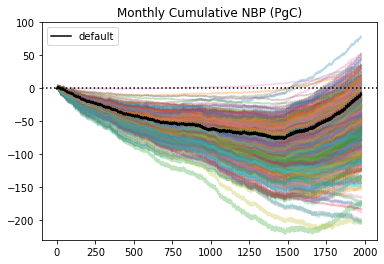

In [13]:
plt.plot(nbp_gm_cumulative.transpose(),alpha=0.3);
plt.plot(nbp_gm_cumulative[0], color='k', zorder=2, label='default')
plt.ylim([-230,100])
plt.legend(loc=2)
plt.axhline(y=0, color='k', linestyle=':')
plt.title('Monthly Cumulative NBP (PgC)');

In [14]:
%%time
nbp_gm_am = amean(nbp_gm)

CPU times: user 65.7 ms, sys: 1.42 ms, total: 67.2 ms
Wall time: 78.3 ms


In [15]:
nbp_gm_am

<xarray.DataArray (year: 165, ens: 501)>
array([[ 0.16873952, -0.16291489, -0.33845324, ..., -1.17339674,
         0.05192251,  0.80171849],
       [-1.45315691, -1.8318503 , -3.76193478, ..., -2.3721116 ,
        -1.48834649, -1.57839331],
       [-0.75805778, -0.57818453, -2.05575169, ..., -1.05247659,
        -1.04845244, -0.98249536],
       ...,
       [ 1.56584699,  1.59155628,  1.39897923, ...,  1.17030311,
         1.37746287,  1.77842817],
       [ 2.53277102,  1.9479716 ,  1.31606528, ...,  2.52920203,
         1.35169408,  2.41900862],
       [ 3.18328065,  3.1631846 ,  1.56369771, ...,  3.19331581,
         1.2438365 ,  2.50419776]])
Coordinates:
  * ens      (ens) object 'LHC0000' 'LHC0001' 'LHC0002' ... 'LHC0499' 'LHC0500'
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014

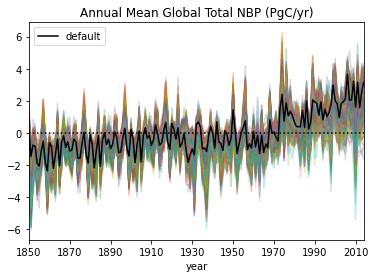

In [16]:
t=1850+np.arange(165)
plt.plot(t, nbp_gm_am, alpha=0.3);
plt.plot(t, nbp_gm_am[:,0], color='k', zorder=2, label='default')
plt.xlim([1850,2014])
plt.legend(loc=2)
plt.axhline(y=0, color='k', linestyle=':')
plt.xlabel('year')
plt.xticks(1850+20*np.arange(9))
plt.title('Annual Mean Global Total NBP (PgC/yr)');
#plt.savefig('../figs/lhc/NBP_annual.png', bbox_inches='tight')

In [17]:
%%time
nbp_cumulative = nbp_gm_am.cumsum(dim='year') # can't use the cumulative function here because amean creates something indexed by year, not "time"

CPU times: user 848 µs, sys: 0 ns, total: 848 µs
Wall time: 854 µs


In [18]:
nbp_cumulative

<xarray.DataArray (year: 165, ens: 501)>
array([[ 1.68739521e-01, -1.62914889e-01, -3.38453236e-01, ...,
        -1.17339674e+00,  5.19225150e-02,  8.01718489e-01],
       [-1.28441739e+00, -1.99476519e+00, -4.10038801e+00, ...,
        -3.54550833e+00, -1.43642397e+00, -7.76674820e-01],
       [-2.04247517e+00, -2.57294972e+00, -6.15613970e+00, ...,
        -4.59798492e+00, -2.48487641e+00, -1.75917018e+00],
       ...,
       [-1.14763241e+01, -2.58823542e+01, -7.74044148e+01, ...,
        -3.08231463e+00, -7.06449627e+01, -2.52048979e+01],
       [-8.94355309e+00, -2.39343826e+01, -7.60883496e+01, ...,
        -5.53112599e-01, -6.92932686e+01, -2.27858893e+01],
       [-5.76027244e+00, -2.07711980e+01, -7.45246519e+01, ...,
         2.64020321e+00, -6.80494321e+01, -2.02816915e+01]])
Coordinates:
  * ens      (ens) object 'LHC0000' 'LHC0001' 'LHC0002' ... 'LHC0499' 'LHC0500'
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014

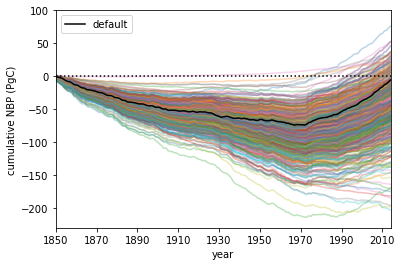

In [19]:
t=1850+np.arange(165)
plt.plot(t, nbp_cumulative, alpha=0.3)
plt.plot(t, nbp_cumulative[:,0], color='k', zorder=2, label='default')
plt.xlim([1850,2014])
plt.ylim([-230,100])
plt.legend(loc=2)
plt.axhline(y=0, color='k', linestyle=':')
plt.xlabel('year')
plt.xticks(1850+20*np.arange(9))
plt.ylabel('cumulative NBP (PgC)');
#plt.savefig('../figs/lhc/NBP_cumulative.png', bbox_inches='tight')

In [31]:
%%time
# test alternate order (annual mean first, then global sum)
nbp_cumulative_test = cf*gmean(amean(ds['NBP']), ds.la).cumsum(dim='year')

CPU times: user 4min 46s, sys: 8.23 s, total: 4min 54s
Wall time: 5min 33s


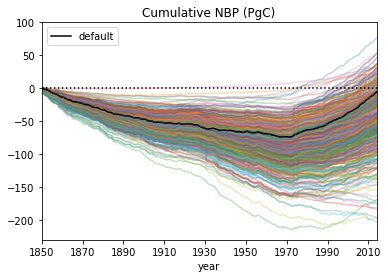

In [32]:
# calculation is the same!
plt.plot(t, nbp_cumulative_test, alpha=0.3);
plt.plot(t, nbp_cumulative_test[:,0], color='k', zorder=2, label='default')
plt.xlim([1850,2014])
plt.ylim([-230,100])
plt.legend(loc=2)
plt.axhline(y=0, color='k', linestyle=':')
plt.xlabel('year')
plt.xticks(1850+20*np.arange(9))
plt.title('Cumulative NBP (PgC)');

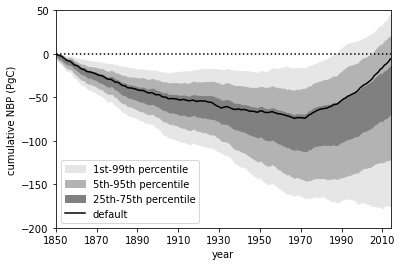

In [20]:
p1=nbp_cumulative[:,1:].quantile(0.01,dim='ens')
p5=nbp_cumulative[:,1:].quantile(0.05,dim='ens')
p25=nbp_cumulative[:,1:].quantile(0.25,dim='ens')
p75=nbp_cumulative[:,1:].quantile(0.75,dim='ens')
p95=nbp_cumulative[:,1:].quantile(0.95,dim='ens')
p99=nbp_cumulative[:,1:].quantile(0.99,dim='ens')

t=1850+np.arange(165)
plt.fill_between(t,p1,p99,color=0.9*np.ones(3),label='1st-99th percentile')
plt.fill_between(t,p5,p95,color=0.7*np.ones(3),label='5th-95th percentile')
plt.fill_between(t,p25,p75,color=0.5*np.ones(3),label='25th-75th percentile')
plt.plot(t, nbp_cumulative[:,0], color='k', zorder=2, label='default')
plt.xlim([1850,2014])
plt.ylim([-200,50])
plt.legend(loc=3)
plt.axhline(y=0, color='k', linestyle=':')
plt.xlabel('year')
plt.xticks(1850+20*np.arange(9))
plt.ylabel('cumulative NBP (PgC)');
#plt.savefig('../figs/lhc/NBP_cumulative_percentiles.png', bbox_inches='tight')

### Make a function for generating carbon flux plots
TO DO: re run for NEE and NPP (removing NPP cumulative sum)

In [109]:
print(ds.NEE.attrs['long_name'])
print(ds.NPP.attrs['long_name'])

net ecosystem exchange of carbon, includes fire and hrv_xsmrpool (latter smoothed over the year), excludes landuse and harvest flux, positive for source
net primary production


In [110]:
print(ds.NEE.units, ds.NPP.units)

gC/m^2/s gC/m^2/s


In [ ]:
fig = plt.figure(figsize=(12,8))

t=minyr+np.arange(nyrs)

qs=[1,5,25]
cs=[0.9,0.7,0.5]
labels=['1st-99th percentile', '5th-95th percentile', '25th-75th percentile']

for i,q in enumerate(qs):
    q1 = nbp_am_cumulative.quantile(q/100,dim='ens')
    q2 = nbp_am_cumulative.quantile(1-q/100,dim='ens')
    plt.fill_between(t,q1,q2,color=cs[i]*np.ones(3),label=labels[i])
    
plt.plot(t, nbp_am_cumulative.sel(ens='LHC0000'), color='k', zorder=2, label='default')
plt.xlim([minyr,maxyr])
plt.ylim([-200,50])
plt.legend(loc=3, fontsize=13)
plt.axhline(y=0, color='k', linestyle=':')
plt.xlabel('Year', fontsize=15)
plt.xticks(minyr+20*np.arange(9), fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Cumulative atmosphere-land flux (PgC)', fontsize=15)
plt.title('Perturbed Parameter Ensemble Spread', fontsize=16);
#plt.savefig('../figs/lhc/NBP_cumulative_percentiles.png', bbox_inches='tight', dpi=300)

In [121]:
def carbon_plot(var, yr0):
    
    # conversion factor for gC/m^2/s to PgC/yr
    cf  = 1e-15*365*24*60*60*1e6*ds.la.sum() 
    
    # multiplying by cf (with land area) turns into a global sum
    gm = cf*gmean(ds[var],ds.la)
    gm.attrs['units'] = 'Pg C/yr'
    
    # weighted annual mean for each year
    gm_am = amean(gm)
    
    # cumulative sum over time, if applicable
    if var=='NBP' or var=='NEE':
        cda = gm_am.cumsum(dim='year')
        cda.attrs['units'] = 'Pg C'
    else:
        cda = gm_am
    
    # generate annual time index
    nyrs = len(cda.year)
    t=yr0+np.arange(nyrs)
    
    # set quantiles, colors and labels
    qs=[1,5,25]
    cs=[0.9,0.7,0.5]
    labels=['1st-99th percentile', '5th-95th percentile', '25th-75th percentile']

    fig = plt.figure(figsize=(12,8))
    
    # calculate quantiles without default
    for i,q in enumerate(qs):
        q1 = cda[:,1:].quantile(q/100,dim='ens')
        q2 = cda[:,1:].quantile(1-q/100,dim='ens')
        plt.fill_between(t,q1,q2,color=cs[i]*np.ones(3),label=labels[i])
    
    # plot default
    plt.plot(t, cda[:,0], color='k', zorder=2, label='default')
    
    # set bounds manually
    plt.xlim([yr0,2014])
    if var=='NBP':
        plt.ylim([-200,50]) # NBP   
    if var=='NEE':
        plt.ylim([-250,100]) # NEE
    
    # legend
    plt.legend(loc=3, fontsize=13)

    # zero line
    plt.axhline(y=0, color='k', linestyle=':')

    # labels
    plt.xlabel('Year', fontsize=15)
    plt.xticks(yr0+20*np.arange(9), fontsize=12)
    plt.yticks(fontsize=12)
    
    if var=='NBP' or var=='NEE':
        plt.ylabel('Cumulative '+var+' (PgC)', fontsize=15)
    if var=='NPP':
        plt.ylabel('Annual Mean '+var+' (PgC/yr)', fontsize=15)
    
    # save plot
    if var=='NBP' or var=='NEE':
        plt.savefig('../figs/lhc/'+var+'_cumulative_percentiles.png', bbox_inches='tight')
    if var=='NPP':
        plt.savefig('../figs/lhc/'+var+'_amean_percentiles.png', bbox_inches='tight')

/glade/work/kdagon/miniconda/envs/ppe-py/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6


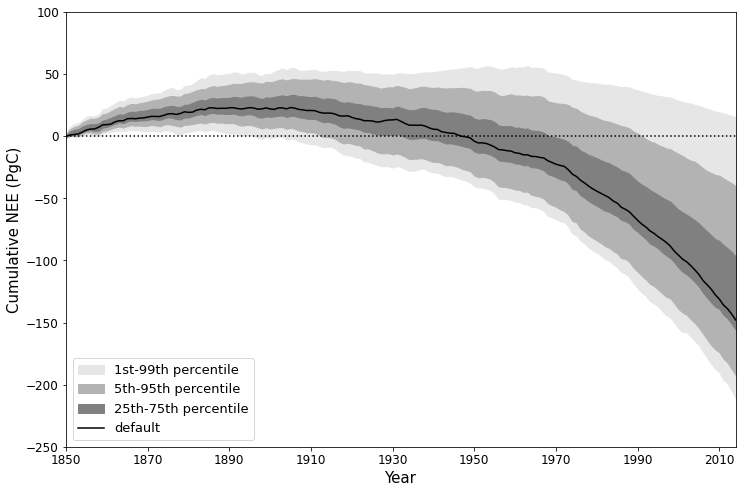

In [116]:
carbon_plot('NEE', 1850)

<xarray.DataArray (year: 165, ens: 501)>
array([[45.08015209, 50.363043  , 45.85650226, ..., 41.17981167,
        34.04569388, 45.00105667],
       [44.40066628, 49.87040694, 44.03429026, ..., 41.13735471,
        32.84024055, 43.73908609],
       [45.44569111, 50.6894337 , 45.15413047, ..., 41.87932573,
        33.7356272 , 43.85161185],
       ...,
       [55.77757768, 63.36498132, 56.58855284, ..., 51.52224363,
        42.21789441, 56.80464906],
       [57.78159555, 65.75722401, 57.14364405, ..., 53.54027923,
        42.88592758, 58.91034979],
       [59.37583293, 67.51826761, 58.34863358, ..., 55.1253527 ,
        43.01013889, 59.34648763]])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
Dimensions without coordinates: ens


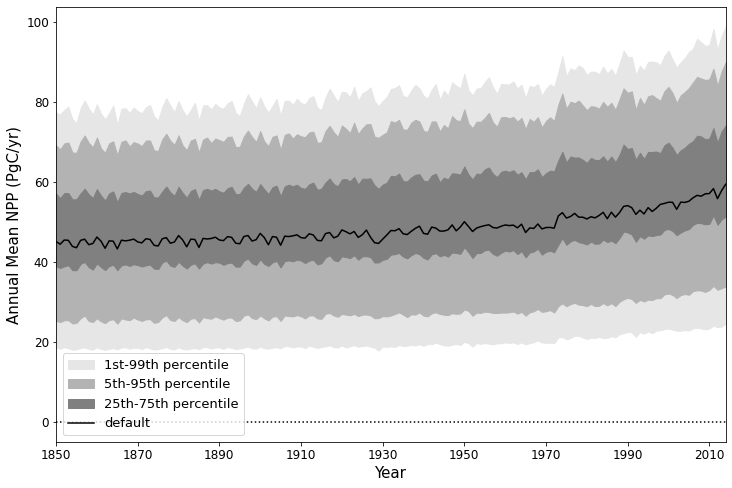

In [120]:
carbon_plot('NPP', 1850)

## Save out processed data

### Parameter scaling factors

In [190]:
parameters = ds.params.values
xd=[]
for i,p in enumerate(parameters):
    xp = ds[parameters[i]]
    xd.append(xp[1:]) # drop default
x = xr.DataArray(xd,dims=('param','ens'),coords=dict(param=ds.params, ens=ds.key[1:]))

In [191]:
x

<xarray.DataArray (param: 32, ens: 500)>
array([[0.77831114, 0.31932864, 0.87677181, ..., 0.18596905, 0.26212961,
        0.42211367],
       [0.35802577, 0.54880317, 0.21079367, ..., 0.996422  , 0.9122803 ,
        0.83921159],
       [0.25502127, 0.63019079, 0.6621252 , ..., 0.42220946, 0.5339336 ,
        0.14434242],
       ...,
       [0.39361723, 0.04108439, 0.81974643, ..., 0.24264258, 0.71595008,
        0.21237027],
       [0.07896155, 0.27561916, 0.84014328, ..., 0.84227481, 0.35301486,
        0.36344002],
       [0.68458797, 0.87845469, 0.95191497, ..., 0.7311443 , 0.3580522 ,
        0.1567103 ]])
Coordinates:
  * param    (param) <U19 'FUN_fracfixers' 'KCN' ... 'tpuse_sf' 'wc2wjb0'
  * ens      (ens) <U7 'LHC0001' 'LHC0002' 'LHC0003' ... 'LHC0499' 'LHC0500'

In [193]:
x.to_netcdf('./processed_data/lhc220926.nc', mode='w', format='NETCDF4')

### Global annual means for a set of variables

In [97]:
# outputs = global annual means (or whatever is of interest)
dset_means = xr.concat(ds_means, dim='var')

In [98]:
dset_means = dset_means.assign_coords(dict(var=dvs, ens=ds.key))

In [99]:
dset_means

<xarray.DataArray (var: 5, ens: 501)>
array([[ 2.12499376e+00,  2.48840346e+00,  2.09403108e+00, ...,
         1.73526726e+00,  1.79285669e+00,  1.97762295e+00],
       [ 3.23992667e-05,  3.83255422e-05,  3.83618985e-05, ...,
         2.77650705e-05,  2.81621755e-05,  3.49206757e-05],
       [ 2.88894903e+01,  3.06119438e+01,  3.19234644e+01, ...,
         2.93918513e+01,  3.34961154e+01,  3.07105945e+01],
       [ 3.86245898e+01,  4.67823344e+01,  4.27290538e+01, ...,
         3.95738546e+01,  3.84288677e+01,  3.91113949e+01],
       [-3.65146216e-06, -3.43283931e-05, -1.00538247e-05, ...,
        -9.46101668e-07, -5.79495269e-06, -1.87765041e-05]])
Coordinates:
  * var      (var) <U14 'TLAI' 'GPP' 'SOILWATER_10CM' 'EFLX_LH_TOT' 'QHR'
  * ens      (ens) <U7 'LHC0000' 'LHC0001' 'LHC0002' ... 'LHC0499' 'LHC0500'

In [100]:
dset_means.to_netcdf('./processed_data/fivevars_gmean_amean_2005-2014.nc', mode='w', format='NETCDF4')

### Global mean monthly climo for a set of variables

In [101]:
dset_mclimo = xr.concat(ds_gm_mclimo, dim='var')

In [102]:
dset_mclimo = dset_mclimo.assign_coords(dict(var=dvs, ens=ds.key))

In [103]:
dset_mclimo

<xarray.DataArray (var: 5, ens: 501, month: 12)>
array([[[ 1.94610385e+00,  1.87300433e+00,  1.84502899e+00, ...,
          2.10703139e+00,  2.11695789e+00,  2.07717746e+00],
        [ 2.32894271e+00,  2.25174250e+00,  2.22197245e+00, ...,
          2.44890577e+00,  2.46362034e+00,  2.44101291e+00],
        [ 1.90742960e+00,  1.85405031e+00,  1.81835747e+00, ...,
          2.04693860e+00,  2.04720111e+00,  1.99915225e+00],
        ...,
        [ 1.58355840e+00,  1.52415646e+00,  1.49960777e+00, ...,
          1.70202616e+00,  1.74616303e+00,  1.70618235e+00],
        [ 1.63727827e+00,  1.58188206e+00,  1.55629385e+00, ...,
          1.76436509e+00,  1.78962144e+00,  1.74397115e+00],
        [ 1.83354170e+00,  1.77546295e+00,  1.74300025e+00, ...,
          1.93081178e+00,  1.93149176e+00,  1.92038173e+00]],

       [[ 2.39116004e-05,  2.40453989e-05,  2.54393338e-05, ...,
          2.72344338e-05,  2.50673596e-05,  2.44536005e-05],
        [ 2.91537955e-05,  2.94226094e-05,  3.13815779e-05, ...,
          3.19459710e-05,  2.99094981e-05,  2.93411135e-05],
        [ 2.91116538e-05,  2.96591211e-05,  3.06104812e-05, ...,
          3.26449950e-05,  2.98516525e-05,  2.91609109e-05],
...
        [ 3.11592334e+01,  3.17556771e+01,  3.32622468e+01, ...,
          3.47061844e+01,  3.21531316e+01,  3.13806456e+01],
        [ 3.00378399e+01,  3.12503637e+01,  3.22285056e+01, ...,
          3.43935363e+01,  3.05091342e+01,  2.95902465e+01],
        [ 3.03694302e+01,  3.13882887e+01,  3.25249460e+01, ...,
          3.51489764e+01,  3.07992283e+01,  2.97970377e+01]],

       [[-3.53525760e-06, -3.28369790e-06, -3.07715880e-06, ...,
         -3.79626755e-06, -4.48052155e-06, -3.95468626e-06],
        [-5.66152320e-05, -5.53105198e-05, -4.22211086e-05, ...,
         -1.63806478e-05, -2.92787190e-05, -4.77222867e-05],
        [-1.17996709e-05, -1.20264217e-05, -9.67031627e-06, ...,
         -9.67235946e-06, -1.29210601e-05, -1.27540663e-05],
        ...,
        [-7.69767785e-07, -7.49562190e-07, -7.20358656e-07, ...,
         -1.10166967e-06, -1.04067532e-06, -8.35858225e-07],
        [-5.80060875e-06, -5.59436776e-06, -5.30885604e-06, ...,
         -6.70053666e-06, -8.03710748e-06, -6.75302463e-06],
        [-2.86697867e-05, -2.75598379e-05, -2.36441866e-05, ...,
         -1.16307744e-05, -1.80288447e-05, -2.32858449e-05]]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * var      (var) <U14 'TLAI' 'GPP' 'SOILWATER_10CM' 'EFLX_LH_TOT' 'QHR'
  * ens      (ens) <U7 'LHC0000' 'LHC0001' 'LHC0002' ... 'LHC0499' 'LHC0500'

In [104]:
dset_mclimo.to_netcdf('./processed_data/fivevars_gmean_mclimo_2005-2014.nc', mode='w', format='NETCDF4')

### Global sum monthly NBP

In [39]:
nbp_gm = nbp_gm.assign_coords(dict(ens=ds.key))

In [40]:
nbp_gm.attrs['units'] = 'PgC/yr'

In [41]:
nbp_gm

<xarray.DataArray (ens: 501, time: 1980)>
array([[ -2.34929196,  -1.03410223,  -0.96948324, ..., -11.41224174,
        -10.25269781,  -6.55507597],
       [ -6.06095924,  -5.65566814,  -4.48109455, ..., -14.03205545,
        -14.36161151, -10.43655177],
       [ -3.96090221,  -2.52441813,  -2.65064144, ..., -11.92618123,
        -13.56890635,  -9.63159068],
       ...,
       [ -3.06333037,  -2.52800581,  -1.76847494, ...,  -9.02584446,
         -6.46198424,  -4.57033172],
       [ -1.55071676,  -0.33176715,  -0.39397112, ..., -10.58907563,
         -7.09781847,  -4.66155674],
       [ -3.44429417,  -2.09034548,  -1.19150309, ...,  -9.9672039 ,
        -10.59203605,  -6.58971481]])
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2014-12-01 00:00:00
  * ens      (ens) <U7 'LHC0000' 'LHC0001' 'LHC0002' ... 'LHC0499' 'LHC0500'
Attributes:
    units:    PgC/yr

In [42]:
%%time
nbp_gm.to_netcdf('./processed_data/nbp_globalsum_1850-2014.nc', mode='w', format='NETCDF4')

CPU times: user 75.7 ms, sys: 22.9 ms, total: 98.6 ms
Wall time: 1.41 s


In [122]:
client.close()
cluster.close()